In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import os
import sys
from multiprocessing import Pool
from tqdm.auto import tqdm
import networkx as nx
import matplotlib.pyplot as plt

In [3]:
project_root = os.path.abspath(
    os.path.join("C:/Users/jllgo/OneDrive/Documentos/UFMG/MSc & MSI 2/MatchSegmentation")
)
if project_root not in sys.path:
    sys.path.append(project_root)

In [4]:
from src.pass_networks.process_events import get_match_events
import gandula
from gandula.export.dataframe import pff_frames_to_dataframe
import pandas as pd
import numpy as np

In [5]:
RAW_DATA_PATH = '../data/raw/PL-22-23'
INTERMEDIATE_DATA_PATH = '../data/intermediate/PL-22-23'
PROCESSED_DATA_PATH = "../data/processed/PL-22-23"
CSV_DATA_PATH = "../data/csv"

# 1. Get Data

In [6]:
metadata_df, players_df = pff_frames_to_dataframe(
        gandula.get_frames(
            RAW_DATA_PATH,
            4625,
        )
    )

Loading frames from match 4625: 0 frames [00:00, ? frames/s]

Validating frames:   0%|          | 0/176875 [00:00<?, ? frames/s]

In [7]:
len(metadata_df), len(players_df)

(176875, 2722346)

In [8]:
players_df['frame_id']=players_df['frame_id'].astype(int)
players_df['match_id']=players_df['match_id'].astype(int)
players_df['period']=players_df['period'].astype(int)
players_df['shirt']=players_df['shirt'].astype(int)
players_df.head()

,elapsed_seconds,frame_id,match_id,period,shirt,x,y,team,ball_x,ball_y,ball_z
0,0.000475,5259,4625,1,22,16.884,-8.001,home,-1.51,0.62,0.0
1,0.000475,5259,4625,1,8,7.807,13.295,home,-1.51,0.62,0.0
2,0.000475,5259,4625,1,24,9.220,-2.094,home,-1.51,0.62,0.0
3,0.000475,5259,4625,1,10,-0.049,-9.735,home,-1.51,0.62,0.0
4,0.000475,5259,4625,1,18,-0.275,8.588,home,-1.51,0.62,0.0


In [9]:
metadata_df['seconds'] = metadata_df['elapsed_seconds']*metadata_df['period']
metadata_df['interval_id'] =  (metadata_df['seconds']//120 )+ 1
metadata_df['interval_id'] = metadata_df['interval_id'].astype(int)
metadata_df['match_id'] = metadata_df['match_id'].astype(int)
metadata_df['period'] = metadata_df['period'].astype(int)
metadata_df['frame_id'] = metadata_df['frame_id'].astype(int)

metadata_df.head()

,match_id,frame_id,period,elapsed_seconds,home_has_possession,event_id,event_type,event_setpiece_type,event_player_id,event_team_id,...,event_end_frame,possession_id,possession_type,possession_start_frame,possession_end_frame,sequence,version,video_time_milli,seconds,interval_id
0,4625,5259,1,0.000475,0.0,6911618.0,PFF_Frame_GameEventType.FIRST_HALF_KICKOFF,SetPieceType.KICK_OFF,7001.0,221.0,...,5259.0,6801909.0,Frame_PossessionEventType.PASS,5259.0,5259.0,1.0,4.1.0,175475.475,0.000475,1
1,4625,5260,1,0.033842,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,4.1.0,175508.842,0.033842,1
2,4625,5261,1,0.067209,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,4.1.0,175542.209,0.067209,1
3,4625,5262,1,0.100576,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,4.1.0,175575.576,0.100576,1
4,4625,5263,1,0.133942,0.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,4.1.0,175608.942,0.133942,1


In [10]:
events_df = get_match_events(4625)

events_df['event_id'] = events_df['event_id'].astype(int)
events_df['possession_id'] = events_df['possession_id'].astype(int)

events_df.head()

,match_id,team_id,event_id,possession_id,possession_type,player_id,receiver_id,outcome,carry_type
0,4625,221,6911618,6801909,PASS,7001,230,C,None
1,4625,221,6911620,6801911,PASS,230,1374,C,None
2,4625,221,6911624,6801915,PASS,1374,243,C,None
3,4625,221,6911636,6801926,PASS,243,4927,C,None
4,4625,221,6911648,6801937,PASS,4927,None,D,None


In [11]:
players_info = pd.read_csv(CSV_DATA_PATH+'/players_matches.csv')
players_info.head(5)

,player_id,first_name,last_name,nickname,team_id,position,shirt_number,match_id
0,1,Harry,Kane,Harry Kane,17,CF,10,4481
1,1,Harry,Kane,Harry Kane,17,CF,10,4593
2,1,Harry,Kane,Harry Kane,17,CF,10,4544
3,1,Harry,Kane,Harry Kane,17,CF,10,4613
4,1,Harry,Kane,Harry Kane,17,CF,10,4503


In [12]:
players_info[players_info['player_id']==3972]

,player_id,first_name,last_name,nickname,team_id,position,shirt_number,match_id
5304,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4582
5305,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4546
5306,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4625
5307,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4543
5308,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4532
5309,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4589
5310,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4570
5311,3972,Duje,Caleta-Car,Duje Caleta-Car,16,LCB,6,4524
5312,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4506
5313,3972,Duje,Caleta-Car,Duje Caleta-Car,16,RCB,6,4605


In [13]:
teams_info = pd.read_csv(CSV_DATA_PATH+'/teams.csv')
teams_info.head(5)

,team_id,team_name,team_short_name,team_country,primary_color,secondary_color
0,1,AFC Bournemouth,BOU,England,#E20613,#000000
1,2,Arsenal,ARS,England,#E10B17,#FFFFFF
2,3,Aston Villa,AVL,England,#660E36,#93BDE4
3,4,Brighton & Hove Albion,BHA,England,#0A55A2,#FFFFFF
4,6,Chelsea,CHE,England,#184890,#1D1D1D


In [14]:
games_info = pd.read_csv(CSV_DATA_PATH+'/games.csv')
games_info.head(5)

,match_id,season,week,date,home_team_id,home_team_name,away_team_id,away_team_name,competition_id,competition_name,home_team_start_left
0,4436,2022-2023,1,2022-08-05 19:00:00,7,Crystal Palace,2,Arsenal,1,Premier League,True
1,4437,2022-2023,1,2022-08-06 11:30:00,54,Fulham,10,Liverpool,1,Premier League,True
2,4438,2022-2023,1,2022-08-06 14:00:00,1,AFC Bournemouth,3,Aston Villa,1,Premier League,False
3,4439,2022-2023,1,2022-08-06 14:00:00,55,Leeds United,20,Wolverhampton Wanderers,1,Premier League,True
4,4440,2022-2023,1,2022-08-07 13:00:00,9,Leicester City,119,Brentford,1,Premier League,True


# 2. Preprocess Data

In [15]:
players_info = players_info[players_info['match_id'] == 4625].reset_index(drop=True)
players_info

,player_id,first_name,last_name,nickname,team_id,position,shirt_number,match_id
0,72,Serge,Aurier,Serge Aurier,221,RB,24,4625
1,73,Kyle,Walker-Peters,Kyle Walker-Peters,16,RWB,2,4625
2,89,Willy,Caballero,Willy Caballero,16,GK,13,4625
3,154,Ainsley,Maitland-Niles,Ainsley Maitland-Niles,16,RM,3,4625
4,230,Willy,Boly,Willy Boly,221,LCB,30,4625
5,243,Morgan,Gibbs-White,Morgan Gibbs-White,221,AM,10,4625
6,285,Steve,Cook,Steve Cook,221,RCB,3,4625
7,314,Sam,Surridge,Sam Surridge,221,CF,16,4625
8,334,Jack,Colback,Jack Colback,221,DM,8,4625
9,394,James,Ward-Prowse,James Ward-Prowse,16,CM,8,4625


In [16]:
metadata_events_df = metadata_df[((metadata_df['frame_id']==metadata_df['possession_start_frame'])) & (metadata_df['event_setpiece_type'].isnull())]

metadata_events_df['frame_id'] = metadata_events_df['frame_id'].astype(int)
metadata_events_df['event_id'] = metadata_events_df['event_id'].astype(int)
metadata_events_df['event_start_frame'] = metadata_events_df['event_start_frame'].astype(int)
metadata_events_df['event_end_frame'] = metadata_events_df['event_end_frame'].astype(int)
metadata_events_df['possession_id'] = metadata_events_df['possession_id'].astype(float)
metadata_events_df['possession_start_frame'] = metadata_events_df['possession_start_frame'].astype(int)
metadata_events_df['possession_end_frame'] = metadata_events_df['possession_end_frame'].astype(int)
metadata_events_df['period'] = metadata_events_df['period'].astype(int)
metadata_events_df['match_id'] = metadata_events_df['match_id'].astype(int)

metadata_events_df.head()

C:\Users\jllgo\AppData\Local\Temp\ipykernel_7208\4041002680.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_events_df['frame_id'] = metadata_events_df['frame_id'].astype(int)
C:\Users\jllgo\AppData\Local\Temp\ipykernel_7208\4041002680.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  metadata_events_df['event_id'] = metadata_events_df['event_id'].astype(int)
C:\Users\jllgo\AppData\Local\Temp\ipykernel_7208\4041002680.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a sl

,match_id,frame_id,period,elapsed_seconds,home_has_possession,event_id,event_type,event_setpiece_type,event_player_id,event_team_id,...,event_end_frame,possession_id,possession_type,possession_start_frame,possession_end_frame,sequence,version,video_time_milli,seconds,interval_id
100,4625,5359,1,3.337145,0.0,6911620,PFF_Frame_GameEventType.ON_THE_BALL,None,230.0,221.0,...,5359,6801911.0,Frame_PossessionEventType.PASS,5359,5359,1.0,4.1.0,178812.145,3.337145,1
202,4625,5461,1,6.740549,0.0,6911624,PFF_Frame_GameEventType.ON_THE_BALL,None,1374.0,221.0,...,5461,6801915.0,Frame_PossessionEventType.PASS,5461,5461,1.0,4.1.0,182215.549,6.740549,1
242,4625,5501,1,8.075217,0.0,6911636,PFF_Frame_GameEventType.ON_THE_BALL,None,243.0,221.0,...,5501,6801926.0,Frame_PossessionEventType.PASS,5501,5501,1.0,4.1.0,183550.217,8.075217,1
311,4625,5570,1,10.377519,0.0,6911648,PFF_Frame_GameEventType.ON_THE_BALL,None,4927.0,221.0,...,5619,6801936.0,Frame_PossessionEventType.CHALLENGE,5570,5619,1.0,4.1.0,185852.519,10.377519,1
360,4625,5619,1,12.012487,0.0,6911648,PFF_Frame_GameEventType.ON_THE_BALL,None,4927.0,221.0,...,5619,6801937.0,Frame_PossessionEventType.PASS,5619,5619,1.0,4.1.0,187487.487,12.012487,1


In [17]:
players_df = players_df.merge(
    games_info[['match_id', 'home_team_id', 'away_team_id']],
    on='match_id',
    how='left'
)

In [18]:
players_df['team_id'] = np.where(
    players_df['team'] == 'home',
    players_df['home_team_id'],
    players_df['away_team_id']
)
players_df.drop(['home_team_id', 'away_team_id'], axis=1, inplace=True)

players_df = players_df.merge(metadata_events_df[['match_id','frame_id','interval_id']], on=['match_id','frame_id'], how='left')
players_df.head()

,elapsed_seconds,frame_id,match_id,period,shirt,x,y,team,ball_x,ball_y,ball_z,team_id,interval_id
0,0.000475,5259,4625,1,22,16.884,-8.001,home,-1.51,0.62,0.0,16,NaN
1,0.000475,5259,4625,1,8,7.807,13.295,home,-1.51,0.62,0.0,16,NaN
2,0.000475,5259,4625,1,24,9.220,-2.094,home,-1.51,0.62,0.0,16,NaN
3,0.000475,5259,4625,1,10,-0.049,-9.735,home,-1.51,0.62,0.0,16,NaN
4,0.000475,5259,4625,1,18,-0.275,8.588,home,-1.51,0.62,0.0,16,NaN


In [19]:
players_info

,player_id,first_name,last_name,nickname,team_id,position,shirt_number,match_id
0,72,Serge,Aurier,Serge Aurier,221,RB,24,4625
1,73,Kyle,Walker-Peters,Kyle Walker-Peters,16,RWB,2,4625
2,89,Willy,Caballero,Willy Caballero,16,GK,13,4625
3,154,Ainsley,Maitland-Niles,Ainsley Maitland-Niles,16,RM,3,4625
4,230,Willy,Boly,Willy Boly,221,LCB,30,4625
5,243,Morgan,Gibbs-White,Morgan Gibbs-White,221,AM,10,4625
6,285,Steve,Cook,Steve Cook,221,RCB,3,4625
7,314,Sam,Surridge,Sam Surridge,221,CF,16,4625
8,334,Jack,Colback,Jack Colback,221,DM,8,4625
9,394,James,Ward-Prowse,James Ward-Prowse,16,CM,8,4625


In [20]:
players_df = players_df.merge(players_info, left_on=['match_id','team_id','shirt'], right_on=['match_id','team_id','shirt_number'], how='left').drop_duplicates().reset_index(drop=True)
players_df.head()

,elapsed_seconds,frame_id,match_id,period,shirt,x,y,team,ball_x,ball_y,ball_z,team_id,interval_id,player_id,first_name,last_name,nickname,position,shirt_number
0,0.000475,5259,4625,1,22,16.884,-8.001,home,-1.51,0.62,0.0,16,NaN,1910,Mohammed,Salisu,Mohammed Salisu,LCB,22
1,0.000475,5259,4625,1,8,7.807,13.295,home,-1.51,0.62,0.0,16,NaN,394,James,Ward-Prowse,James Ward-Prowse,CM,8
2,0.000475,5259,4625,1,24,9.220,-2.094,home,-1.51,0.62,0.0,16,NaN,400,Mohamed,Elyounoussi,Mohamed Elyounoussi,CM,24
3,0.000475,5259,4625,1,10,-0.049,-9.735,home,-1.51,0.62,0.0,16,NaN,403,Che,Adams,Che Adams,CF,10
4,0.000475,5259,4625,1,18,-0.275,8.588,home,-1.51,0.62,0.0,16,NaN,4282,Sékou,Mara,Sékou Mara,CF,18


# 3. Filter and Group

In [21]:
players_interval_df = players_df.groupby(['match_id','interval_id','team_id','player_id','nickname','shirt']).agg(
    x=('x', 'mean'),
    y=('y', 'mean')
).reset_index()

players_interval_df['player_id'] = players_interval_df['player_id'].astype(int)
players_interval_df['match_id'] = players_interval_df['match_id'].astype(int)
players_interval_df['interval_id'] = players_interval_df['interval_id'].astype(int)
players_interval_df['team_id'] = players_interval_df['team_id'].astype(int)
players_interval_df['shirt'] = players_interval_df['shirt'].astype(int)

players_interval_df[players_interval_df['interval_id']==1]

,match_id,interval_id,team_id,player_id,nickname,shirt,x,y
0,4625,1,16,73,Kyle Walker-Peters,2,0.597868,6.800421
1,4625,1,16,394,James Ward-Prowse,8,-1.864000,11.520316
2,4625,1,16,400,Mohamed Elyounoussi,24,-2.814684,6.258316
3,4625,1,16,403,Che Adams,10,-3.099605,12.865211
4,4625,1,16,1910,Mohammed Salisu,22,-0.154395,5.371816
5,4625,1,16,3972,Duje Caleta-Car,6,-10.856750,10.377062
6,4625,1,16,4282,Sékou Mara,18,-2.807132,12.892263
7,4625,1,16,4630,Armel Bella-Kotchap,37,7.570500,15.786773
8,4625,1,16,5114,Romain Perraud,15,3.137947,5.546395
9,4625,1,16,5960,Lyanco,4,3.204842,3.131711


In [22]:
pass_df = events_df[(events_df['possession_type']=='PASS') & (events_df['outcome']=='C')][['match_id','player_id','receiver_id','event_id','possession_id','team_id']]
pass_df

,match_id,player_id,receiver_id,event_id,possession_id,team_id
0,4625,7001,230,6911618,6801909,221
1,4625,230,1374,6911620,6801911,221
2,4625,1374,243,6911624,6801915,221
3,4625,243,4927,6911636,6801926,221
8,4625,1374,8328,6911687,6801976,221
...,...,...,...,...,...,...
849,4625,1910,1910,6919204,6809536,16
850,4625,1910,9992,6919211,6809545,16
852,4625,3972,6656,6919242,6809573,16
854,4625,394,6656,6931483,6822046,16


In [23]:
carry_df = events_df[(events_df['possession_type']=='CARRY') & ((events_df['carry_type'].isin(['T','C'])) | ((events_df['carry_type']=='D')&(events_df['outcome'].isin(['K','B']))))][['match_id','player_id','receiver_id','event_id','possession_id','team_id']]
carry_df

,match_id,player_id,receiver_id,event_id,possession_id,team_id
18,4625,400,400,6911764,6802055,16
21,4625,403,403,6911780,6802072,16
31,4625,1958,1958,6911816,6802106,221
40,4625,4282,4282,6911855,6802150,16
48,4625,4927,4927,6911887,6802179,221
54,4625,4282,4282,6911916,6802210,16
58,4625,1374,1374,6911951,6802249,221
99,4625,7008,7008,6912312,6802617,221
109,4625,4282,4282,6912415,6802714,16
158,4625,8328,8328,6912713,6803002,221


In [24]:
network_df = pd.concat([pass_df,carry_df]).reset_index(drop=True)
network_df

,match_id,player_id,receiver_id,event_id,possession_id,team_id
0,4625,7001,230,6911618,6801909,221
1,4625,230,1374,6911620,6801911,221
2,4625,1374,243,6911624,6801915,221
3,4625,243,4927,6911636,6801926,221
4,4625,1374,8328,6911687,6801976,221
...,...,...,...,...,...,...
622,4625,400,400,6917490,6822244,16
623,4625,403,403,6917511,6807882,16
624,4625,9992,9992,6918560,6814344,16
625,4625,14116,14116,6918809,6809144,221


In [25]:
network_frame_df = network_df.merge(metadata_events_df[['match_id','interval_id','frame_id','event_id','possession_id']], on=['match_id','event_id','possession_id'], how='left')
network_frame_df

,match_id,player_id,receiver_id,event_id,possession_id,team_id,interval_id,frame_id
0,4625,7001,230,6911618,6801909,221,NaN,NaN
1,4625,230,1374,6911620,6801911,221,1.0,5359.0
2,4625,1374,243,6911624,6801915,221,1.0,5461.0
3,4625,243,4927,6911636,6801926,221,1.0,5501.0
4,4625,1374,8328,6911687,6801976,221,NaN,NaN
...,...,...,...,...,...,...,...,...
623,4625,400,400,6917490,6822244,16,30.0,147989.0
624,4625,403,403,6917511,6807882,16,31.0,148280.0
625,4625,9992,9992,6918560,6814344,16,42.0,169533.0
626,4625,14116,14116,6918809,6809144,221,45.0,173954.0


In [26]:
grouped_df = network_frame_df.groupby(['match_id','interval_id','team_id','player_id','receiver_id']).size().reset_index(name='count')
grouped_df ['match_id']=grouped_df['match_id'].astype(int)
grouped_df ['interval_id']=grouped_df['interval_id'].astype(int)
grouped_df ['team_id']=grouped_df['team_id'].astype(int)
grouped_df ['player_id']=grouped_df['player_id'].astype(int)
grouped_df ['receiver_id']=grouped_df['receiver_id'].astype(int)
grouped_df[grouped_df['interval_id']==1]

,match_id,interval_id,team_id,player_id,receiver_id,count
0,4625,1,16,1910,9990,1
1,4625,1,16,3972,403,1
2,4625,1,16,3972,5114,1
3,4625,1,16,400,400,1
4,4625,1,16,400,5114,2
5,4625,1,16,403,4282,1
6,4625,1,16,5114,3972,1
7,4625,1,16,9990,3972,1
8,4625,1,221,1374,243,1
9,4625,1,221,230,1374,1


In [28]:
grouped_df = grouped_df.merge(players_info[['match_id','player_id','nickname','shirt_number']], how='left', left_on=['match_id','player_id'], right_on=['match_id','player_id']).drop_duplicates().reset_index(drop=True)
grouped_df = grouped_df.merge(players_info[['match_id','player_id','nickname','shirt_number']], how='left', left_on=['match_id','receiver_id'], right_on=['match_id','player_id'], suffixes=('_player','_receiver')).drop_duplicates().reset_index(drop=True)
grouped_df

,match_id,interval_id,team_id,player_id_player,receiver_id,count,nickname_player,shirt_number_player,player_id_receiver,nickname_receiver,shirt_number_receiver
0,4625,1,16,1910,9990,1,Mohammed Salisu,22,9990,Gavin Bazunu,31
1,4625,1,16,3972,403,1,Duje Caleta-Car,6,403,Che Adams,10
2,4625,1,16,3972,5114,1,Duje Caleta-Car,6,5114,Romain Perraud,15
3,4625,1,16,400,400,1,Mohamed Elyounoussi,24,400,Mohamed Elyounoussi,24
4,4625,1,16,400,5114,2,Mohamed Elyounoussi,24,5114,Romain Perraud,15
...,...,...,...,...,...,...,...,...,...,...,...
513,4625,48,16,3972,400,1,Duje Caleta-Car,6,400,Mohamed Elyounoussi,24
514,4625,48,16,73,396,1,Kyle Walker-Peters,2,396,Stuart Armstrong,17
515,4625,48,221,230,334,1,Willy Boly,30,334,Jack Colback,8
516,4625,49,16,1910,1910,1,Mohammed Salisu,22,1910,Mohammed Salisu,22


# 4. Graphs

In [38]:
def create_team_graphs(passes_df, positions_df, interval_id):
    """
    Cria um grafo dirigido (NetworkX) para cada team_id encontrado em 'passes_df'.
    
    Parâmetros:
    ----------
    passes_df: DataFrame com colunas [match_id, team_id, player_id, receiver_id, count].
               Cada linha representa a contagem de passes de 'player_id' -> 'receiver_id'.
    positions_df: DataFrame com colunas [match_id, team_id, player_id, ball_x, ball_y].
                  Cada linha dá a posição média (x,y) daquele jogador no campo.
    
    Retorno:
    --------
    dict onde a chave é o team_id e o valor é um nx.DiGraph.
    Cada grafo tem:
      - Nós = player_id (com atributo 'pos' e 'features' = (ball_x, ball_y))
      - Arestas dirigidas de player_id -> receiver_id (com 'weight' = count).
    """
    
    passes_df = passes_df[passes_df['interval_id'] == interval_id].reset_index(drop=True)
    positions_df = positions_df[positions_df['interval_id'] == interval_id].reset_index(drop=True)


    # Identifica todos os times disponíveis no DF de passes
    teams = passes_df['team_id'].unique()
    graphs_dict = {}

    for team in teams:
        # Filtra o DF de passes para esse time
        sub_passes_df = passes_df[passes_df['team_id'] == team]
        # Filtra o DF de posições para esse time
        sub_positions_df = positions_df[positions_df['team_id'] == team]

        # Cria um grafo dirigido para este time
        G = nx.DiGraph(name=f"team_{team}")

        # Adiciona cada player_id como nó, com atributo de posição (ball_x, ball_y)
        # Vamos supor que cada combinação (match_id, team_id, player_id) seja única
        for row in sub_positions_df.itertuples():
            player_id = row.player_id
            x_coord =  row.x
            y_coord = row.y
            shirt_number = row.shirt

            # Adicionamos o nó, salvando a posição em 'pos' e 'features'
            G.add_node(
                shirt_number,
                pos=(x_coord, y_coord),
                features=(x_coord, y_coord)
            )

        # Adiciona as arestas a partir de sub_passes_df
        # Direção: player_id -> receiver_id, peso = count
        for row in sub_passes_df.itertuples():
            source = row.shirt_number_player
            target = row.shirt_number_receiver
            count = row.count

            # Cria a aresta com peso
            # Se preferir, pode somar caso já exista, mas aqui sobrescrevemos
            G.add_edge(source, target, weight=count)

        # Guarda o grafo no dicionário
        graphs_dict[str(team)] = G
        
    return graphs_dict

In [39]:
graphs = create_team_graphs(grouped_df,players_interval_df,1)
graphs

{'16': <networkx.classes.digraph.DiGraph at 0x1f4c1964770>,
 '221': <networkx.classes.digraph.DiGraph at 0x1f4c196fe60>}

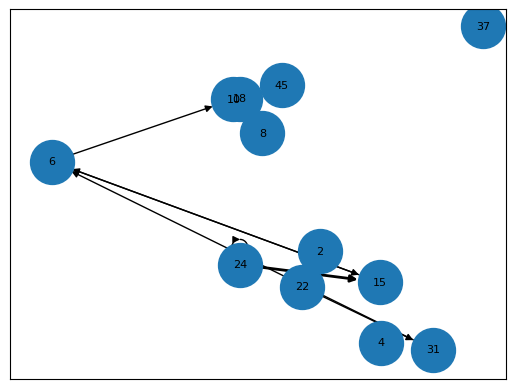

In [40]:
home_graph = graphs['16']
pos = nx.get_node_attributes(home_graph, 'pos')  # pega as posições dos nós
edge_widths = [d['weight'] for (_, _, d) in home_graph.edges(data=True)]  # lista de weights

# Usa draw_networkx, que chama internamente as funções para desenhar nós, arestas e rótulos
nx.draw_networkx(
    home_graph, 
    pos=pos, 
    with_labels=True, 
    node_size=1000, 
    font_size=8, 
    width=edge_widths  # <-- aqui variamos a espessura de cada aresta
)

plt.show()

In [ ]:
pos